# Evaluate the Performance of the Firsov Model
The Firsov Model is a physics-based equation that describes the stopping power a function of position and velocity within a material. In these notebook, we evaluate its performance on predicting the stopping power of Al with the goal of comparing it to our ML model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from stopping_power_ml.firsov import FirsovModel
from pymatgen.io.ase import AseAtomsAdaptor
from scipy.optimize import curve_fit
from functools import partial
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in Fitting Data
We want the random and channel trajectory

In [2]:
random_data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [3]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

In [4]:
with open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb') as fp:
    simulation_cell = pkl.load(fp)

## Remove the Noise at Beginning/End of Simulations
We marked them in a previous notebook, just run the queries

In [5]:
random_data.query('not initial', inplace=True)

In [6]:
channel_data.query('average_range', inplace=True)

## Make the Firsov Functions
The Firsov model is defined by

$F(R, v) = \frac{-0.7h}{(\pi a_B)^2} \left[ \frac{Z_A^2}{(1+0.8 \alpha Z_A^{1/3}R/a)^4} + \frac{Z_B^2}{(1+0.8 (1-\alpha) Z_B^{1/3}R/a)^4} \right] v N$

where $R$ is the distance from the nearest atom, $v$ is the velocity. The rest of the factors have physical meaning (e.g., $Z_A$ and $Z_B$ are the atomic numbers of the projectile and host material), but we will try to fit them.

We have implemented the Firsov model as a ProjectileFeaturizer to leverage the parallelism built into the matminer.

In [7]:
firsov = FirsovModel(simulation_cell)

Plot what it looks like for the channel directory

CPU times: user 3.56 s, sys: 229 ms, total: 3.78 s
Wall time: 3.19 s


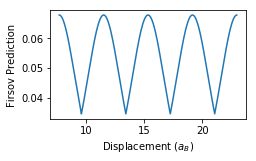

In [8]:
%%time
fig, ax = plt.subplots()

ax.plot(channel_data['displacement'], firsov.featurize_many(channel_data[['position', 'velocity']], pbar=False))

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Firsov Prediction')

fig.set_size_inches(3.5, 2)

*Finding*: It has the right general shape: repeating peaks. However, the magnitude of the force is off

## Determine Optimal Parameters for the Model
The Firsov model has a few adjustable parameters. Because the Firsov model only predicts postive forces, we fit on the channel trajecotory rather than the random. Otherwise, fitting is complicated by figuring out how to overlook this problem of the Firsov model

### Fit the Scale Factor
The scale factor $N$ is the easiest factor to change. Let's set it for the channel

In [9]:
def run_firsov(X, N=1, offset=0, a=0.47, Z_A=1, Z_B=13, alpha=None):
    """Set the parameters of the Firsov model, run it on some data"""
    
    firsov.set_params(N=N, offset=offset, a=a, Z_A=Z_A, Z_B=Z_B, alpha=alpha)
    return firsov.featurize_many(X, pbar=False)

In [10]:
%%time
params, covar = curve_fit(run_firsov, channel_data[['position', 'velocity']], channel_data['force'], 1)

CPU times: user 19.8 s, sys: 1.19 s, total: 20.9 s
Wall time: 21.3 s


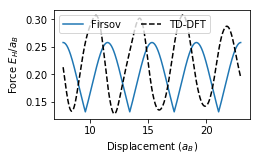

In [11]:
fig, ax = plt.subplots()

ax.plot(channel_data['displacement'], run_firsov(channel_data[['position', 'velocity']], *params), label='Firsov') 
ax.plot(channel_data['displacement'], channel_data['force'], 'k--', label='TD-DFT')

ax.legend(ncol=2)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force $E_H / a_B$')

fig.set_size_inches(3.5, 2)

*Finding*: We can get the magnitude right, but the peaks of the forces are offset

### Fit the Scale Factor and Offset
Try to fix the offset problem

In [12]:
%%time
params, covar = curve_fit(run_firsov, channel_data[['position', 'velocity']], channel_data['force'], [params[0], 0])

CPU times: user 1min 11s, sys: 4.03 s, total: 1min 15s
Wall time: 1min 20s


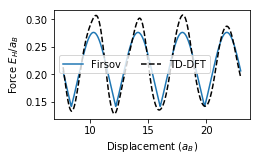

In [13]:
fig, ax = plt.subplots()

ax.plot(channel_data['displacement'], run_firsov(channel_data[['position', 'velocity']], *params), label='Firsov') 
ax.plot(channel_data['displacement'], channel_data['force'], 'k--', label='TD-DFT')

ax.legend(ncol=2)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force $E_H / a_B$')

fig.set_size_inches(3.5, 2)

In [14]:
params

array([4.07323037, 1.20618255])

*Finding*: We can institute a small offset to correct for the problems

## Run the Model on the Random Trajectory
It will not give a perfect fit, but we are looking for qualitative agreement with the peaks in forces and quantitative agreement with the average stopping force.

In [15]:
%%time
forces = firsov.featurize_many(random_data[['position', 'velocity']], pbar=False)

CPU times: user 25.6 s, sys: 799 ms, total: 26.4 s
Wall time: 26.4 s


In [16]:
print('Actual stopping power: {:.3f}'.format(random_data['force'].mean()))
print('Firsov stopping power: {:.3f}'.format(np.mean(forces)))

Actual stopping power: 0.240
Firsov stopping power: 1.424


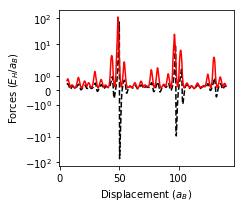

In [17]:
fig, ax = plt.subplots()

ax.plot(random_data['displacement'], random_data['force'], 'k--')
ax.plot(random_data['displacement'], forces, 'r')

ax.set_yscale('symlog')

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Forces ($E_H / a_B$)')

fig.set_size_inches(3.5, 3)
fig.tight_layout()

*Finding*: It does have the right features, qualitatively. The peaks are in the right spots at least. But, the values for close passes are *way* off, which leads to an absurd stopping power of 1.4.

## Save the Model to Disk
Our next step is to evaluate this model on other trajectories

In [18]:
with open('fisov.pkl', 'wb') as fp:
    pkl.dump(firsov, fp)